<a href="https://colab.research.google.com/github/ingridmidory/Inferencia-Est-distica/blob/main/Tarea4_MLModelosPredictivos_MonterrosoAlfaro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#### PASO 1. De la base de datos de COVID más reciente, extraer una muestra aleatoria con tamaño igual al 20% del total de la población.
import pandas as pd
import scipy.stats as ss
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neural_network import MLPClassifier

In [ ]:
#### Importar de la página de la SS los datos actualizados
### hacer la descargar automáticamente 
#### https://buomsoo-kim.github.io/colab/2020/05/04/Colab-downloading-files-from-web-2.md/
!wget --timeout=300 --tries=1 "http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip"

--2021-12-14 18:06:57--  http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip
Resolving datosabiertos.salud.gob.mx (datosabiertos.salud.gob.mx)... 187.210.186.146
Connecting to datosabiertos.salud.gob.mx (datosabiertos.salud.gob.mx)|187.210.186.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241794570 (231M) [application/x-zip-compressed]
Saving to: ‘datos_abiertos_covid19.zip.1’

datos_abiertos_covi 100%[===================>] 230.59M  1.98MB/s    in 2m 29s  

2021-12-14 18:09:26 (1.55 MB/s) - ‘datos_abiertos_covid19.zip.1’ saved [241794570/241794570]



In [ ]:
poblacion = pd.read_csv('datos_abiertos_covid19.zip', encoding='latin-1')
positivos = poblacion[poblacion["CLASIFICACION_FINAL"]<=3]
datos = positivos.sample(frac = 0.05)
print('Poblacion', poblacion.shape)
print('Muestra', datos.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Poblacion (12074161, 40)
Muestra (195949, 40)


In [ ]:
#### PASO 2. Realizar una prueba de normalidad (Shapiro, Anderson-Darling) para la variable “edad”.
#Prueba de normalidad
#Ho: la variable se aproxima a una distribución normal
#Ha: la variable no se aproxima a una distribución normal
ss.shapiro(datos.EDAD)
# Como pvalue = 0.0 < 0.05 se rechaza la hipótes nula. La variable no es normal

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9857981204986572, 0.0)

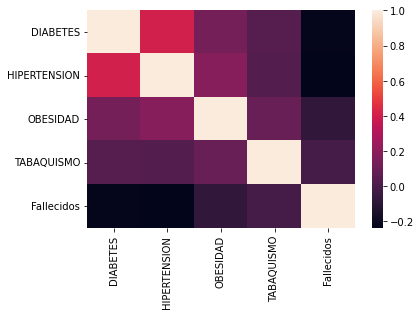

In [ ]:
#### PASO 3. 3. Calcular una matriz de correlaciones para “diabetes”, “hipertensión”, “obesidad”, “tabaquismo” y “fallecido”. Reportar los resultados en un “Heat Map”


datos["Fallecidos"] = np.where(datos["FECHA_DEF"] == '9999-99-99',0,1)
#Heatmap
enfermedades = ["DIABETES","HIPERTENSION","OBESIDAD","TABAQUISMO","Fallecidos"]
sb.heatmap(datos.loc[:,enfermedades].corr(method = "spearman"))

In [ ]:
for x in enfermedades:
    positivos[x] = positivos[x].replace(1,0)
    positivos[x] = positivos[x].replace(2,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


KeyError: ignored

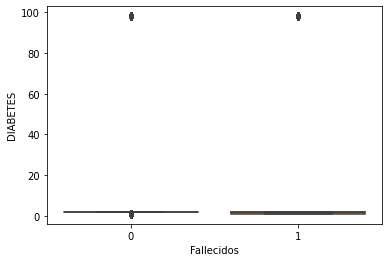

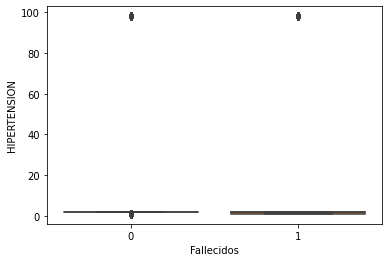

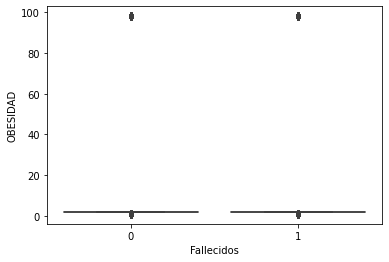

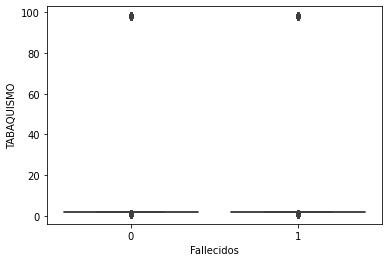

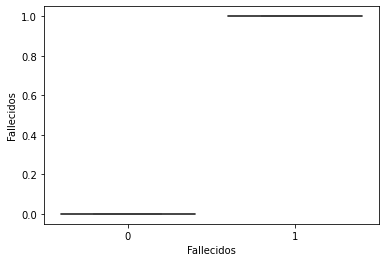

In [ ]:
#### PASO 4. Realizar gráficos box-plot para la variable “fallecido”, con cada una de las comorbilidades y la edad


for y in enfermedades:
    sb.boxplot(x='Fallecidos',y=y,data=datos)
    plt.show()

## 5. Realizar gráficos de barras para la variable “fallecido”, con cada una de las comorbilidades
y la edad. En total serán 5 gráficos

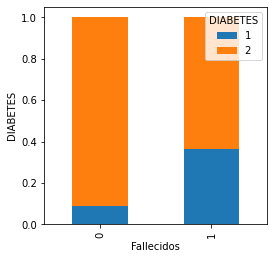

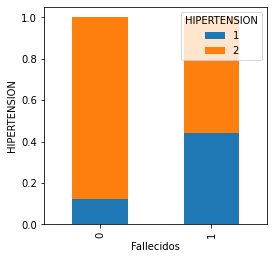

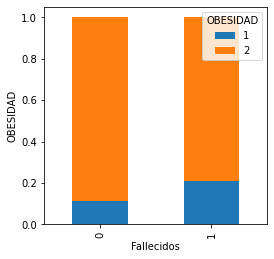

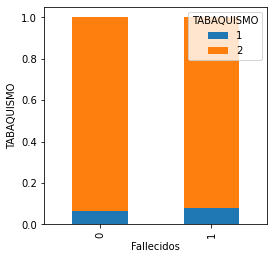

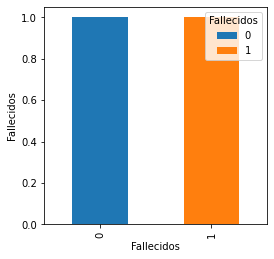

In [ ]:
#### PASO Realizar gráficos de barras para la variable “fallecido”, con cada una de las comorbilidades y la edad.
"HIPERTENSION","OBESIDAD","TABAQUISMO"
datos = datos.loc[(datos["DIABETES"] <=2) & (datos["HIPERTENSION"] <=2) & (datos["OBESIDAD"] <=2) &
                       (datos["TABAQUISMO"] <=2) ]
for y in enfermedades:
    t = pd.crosstab(datos["Fallecidos"],datos[y])
    t.div(t.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
    plt.xlabel("Fallecidos")
    plt.ylabel(y)
    plt.show()


In [ ]:
#### PASO 6. Construir un modelo de Máquina de Soporte Vectorial (classifier). Las variables predictoras son “diabetes”, “hipertensión”, “obesidad” y “tabaquismo”, además de la “edad” (X_test, X_train). La variable independiente es “fallecimiento” (y_test, y_train). Tomaremos en cuenta que la población está desbalanceada,por lo que prodemos con técnica de


from collections import Counter
#Creación de fallecidos
#Separación de datos
datos = positivos
enfermedades = ["DIABETES","HIPERTENSION","OBESIDAD","TABAQUISMO", "EDAD","Fallecidos"]
datos["Fallecidos"] = np.where(datos["FECHA_DEF"] == '9999-99-99',0,1)
datos = datos.loc[(datos["DIABETES"] <=2) & (datos["HIPERTENSION"] <=2) & (datos["OBESIDAD"] <=2) &
                       (datos["TABAQUISMO"] <=2) ]
X = datos.loc[:,enfermedades]
y = datos['Fallecidos']
X.drop('Fallecidos', axis = 1,inplace = True)
print(Counter(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.98, random_state = 0)
print(Counter(y_train))
print(Counter(y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Counter({0: 3611211, 1: 294596})
Counter({0: 72106, 1: 6010})
Counter({0: 3539105, 1: 288586})


In [ ]:
X_test

,DIABETES,HIPERTENSION,OBESIDAD,TABAQUISMO,EDAD
4000375,0,0,0,0,74
8989465,0,0,0,0,61
9809702,0,0,0,0,36
1494517,0,0,0,0,39
4301618,0,0,0,0,46
...,...,...,...,...,...
580962,0,0,0,0,65
3351172,0,0,0,0,28
2966029,0,0,0,0,76
3823160,0,0,0,0,36


In [ ]:
param_grid = {'C': [1,0.1,0.01], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf','sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2,cv=4)
grid.fit(X_train,y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  39.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  39.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  39.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  38.9s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=  19.7s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=  19.7s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=  19.7s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=  19.7s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  35.6s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  36.9s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  35.7s
[CV] END .........................C=1, gamma=0.1

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [1, 0.1, 0.01], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=2)

In [ ]:
print(grid.best_estimator_)


SVC(C=1, gamma=0.1)


In [ ]:
#### PASO 7. Hacer el “Tuneo” del modelo antes con la función “param_grid”

In [ ]:
classifier_svm = SVC(kernel='sigmoid',C = 1,gamma = 1,probability=True).fit(X_train, y_train)


In [ ]:
y_pred_svm = classifier_svm.predict(X_test)


In [ ]:
confusion_matrix(y_test, y_pred_svm)


array([[3527594,   11511],
       [ 288423,     163]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[9.96747483e-01 3.25251723e-03]
 [9.99435177e-01 5.64822964e-04]]


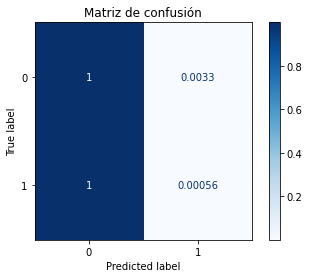

In [ ]:
disp = plot_confusion_matrix(classifier_svm, X_test, y_test,
                             #display_labels=y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Matriz de confusión')
print(disp.confusion_matrix)
plt.show()


In [ ]:
y_pred_prob_svm = classifier_svm.predict_proba(X_test)

In [ ]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_svm[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for SVM')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test,y_pred_svm))

0.07835898979306323


In [ ]:
#### PASO 8. Modelo de redes neuronales

In [ ]:
enfermedades = ["DIABETES","HIPERTENSION","OBESIDAD","TABAQUISMO", "EDAD","Fallecidos"]
X = datos.loc[:,enfermedades]
y = datos['Fallecidos']
X.drop('Fallecidos', axis = 1,inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.98, random_state = 0)
#Tuning
param_grid = {
    'hidden_layer_sizes': [(25,25,25),(5,3,5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
grid = GridSearchCV(MLPClassifier(max_iter=500),param_grid,refit=True,verbose=2,cv=4)
grid.fit(X_train,y_train)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25), learning_rate=constant, solver=sgd; total time=   5.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25), learning_rate=constant, solver=sgd; total time=  11.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25), learning_rate=constant, solver=sgd; total time=  12.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25), learning_rate=constant, solver=sgd; total time=   8.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25), learning_rate=constant, solver=adam; total time=   5.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25), learning_rate=constant, solver=adam; total time=  10.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25), learning_rate=constant, solver=adam; total time=   5.8s
[CV] END activation=tanh, alpha=0.0001,

GridSearchCV(cv=4, estimator=MLPClassifier(max_iter=500),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(25, 25, 25), (5, 3, 5)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=2)

In [ ]:
print(grid.best_estimator_)

MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(5, 3, 5),
              max_iter=500)


In [ ]:
classifier_NN = MLPClassifier(activation='tanh', hidden_layer_sizes=(25, 25, 25), solver='sgd', max_iter=500).fit(X_train, y_train)

In [ ]:
y_pre_NN = classifier_NN.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pre_NN)

array([[3539105,       0],
       [ 288586,       0]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[1. 0.]
 [1. 0.]]


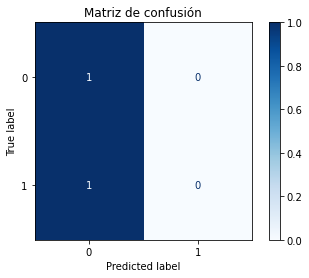

In [ ]:
disp = plot_confusion_matrix(classifier_NN, X_test, y_test,
                             #display_labels=y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Matriz de confusión')
print(disp.confusion_matrix)
plt.show()

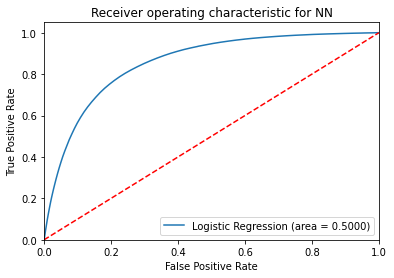

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
y_pred_prob_NN = classifier_NN.predict_proba(X_test)
roc_auc_NN = roc_auc_score(y_test, y_pre_NN)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_NN[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % roc_auc_NN)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for NN')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
print(mean_squared_error(y_test,y_pre_NN))


0.07539427816926705


In [ ]:
data = [[1,2,2,2,10],
        [2,1,2,2,20],
        [2,2,1,2,30],
        [2,2,2,1,40],
        [1,1,2,2,50],
        [2,1,1,2,60],
        [2,2,1,1,70],
        [2,1,2,1,40],
        [1,1,1,1,33],]
X_escenario = pd.DataFrame(data,columns=["DIABETES", "HIPERTENSION", "OBESIDAD", "TABAQUISMO", "EDAD"])

In [ ]:
y_escenario_prob = classifier_NN.predict_proba(X_escenario)


In [ ]:
y_escenario_prob

array([[0.98171017, 0.01828983],
       [0.98938268, 0.01061732],
       [0.97011199, 0.02988801],
       [0.93470187, 0.06529813],
       [0.91275782, 0.08724218],
       [0.86788033, 0.13211967],
       [0.76120589, 0.23879411],
       [0.95386553, 0.04613447],
       [0.96774303, 0.03225697]])